<a href="https://colab.research.google.com/github/saivijayragav/AI-ATC-Assistant/blob/main/Air_Traffic_Controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Team Name:** Algorithm Avengers

# ML-Based Air Traffic Conflict Detection and Decision Support System

This notebook implements an end-to-end machine learning pipeline for monitoring,
analyzing, and predicting air traffic safety risks using real-world ADS-B data.
The system is designed to support air traffic control decision-making by identifying
abnormal aircraft behavior, detecting current and future loss-of-separation risks,
and providing actionable recommendations for conflict mitigation.

## System Overview

The pipeline processes raw aircraft state vectors and applies a combination of
unsupervised learning, supervised learning, physics-based forecasting, and
rule-based decision logic to achieve the following:
- Detect anomalous aircraft behavior in real time
- Predict current loss-of-separation risk between aircraft pairs
- Identify high-density and congested airspace regions
- Forecast short-term aircraft trajectories
- Anticipate future conflicts before they occur
- Generate prioritized, human-actionable safety recommendations
- Present results through an interpretable visualization dashboard

## Data Source

OpenSky Network — historical ADS-B state vector data collected from real-world
air traffic operations and used here for research and demonstration purposes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingRegressor
from sklearn.neighbors import BallTree
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import joblib
import glob

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ Libraries imported successfully")
print("✓ ML modules loaded")


✓ Libraries imported successfully
✓ ML modules loaded


## Data Ingestion & Initial Sampling

This cell loads raw ADS-B aircraft state data from CSV files and performs an initial
sampling step to limit dataset size for exploratory analysis and rapid iteration.

**Data source:**  
OpenSky Network — historical ADS-B state vectors.

The dataset contains time-stamped aircraft position and kinematic information
(latitude, longitude, altitude, velocity, heading, vertical rate, and identifiers)
captured from real-world air traffic.


In [ ]:
csv_files = glob.glob("datasets/states_2022-01-03-00.csv")
print(f"Found {len(csv_files)} files")

df = pd.concat(
    [pd.read_csv(f) for f in csv_files],
    ignore_index=True
)
print("="*80)
print("DATA LOADED SUCCESSFULLY")
df = df[:10000]
print("="*80)
print(f"\nDataset shape: {df.shape}")
print(f"Total records: {len(df)}")
print("\nFirst few rows:")
print(df.head())


Found 1 files
DATA LOADED SUCCESSFULLY

Dataset shape: (10000, 16)
Total records: 10000

First few rows:
         time  icao24        lat        lon    velocity     heading  vertrate  \
0  1641168000  4ca8e8  52.980357   0.948434  193.792496  284.921620   0.00000   
1  1641168000  471f41  42.852219   5.691572  239.283384   55.865788   0.32512   
2  1641168000  aa56d4  38.396844 -77.004905  288.196102   39.059131   0.00000   
3  1641168000  3c4582  52.690109  -1.461182  158.457103  149.355259  26.00960   
4  1641168010  a4ee2e  40.516694 -76.364906  164.960141  281.695403   5.20192   

   callsign  onground  alert    spi  squawk  baroaltitude  geoaltitude  \
0  RYR23RR      False  False  False  2267.0      11582.40     11330.94   
1  WZZ5552      False  False  False  1014.0      10972.80     11300.46   
2  UAL1560      False  False  False  5665.0      11277.60     11422.38   
3  BOX193       False  False  False  2261.0       3695.70      3604.26   
4  AAL2663      False  False  False  1

## Data Cleaning & Feature Engineering

Prepare raw ADS-B aircraft state data into a clean, physically valid, and ML-ready dataset.
This step removes unusable records, reduces data volume, and engineers aviation-specific
features required by downstream machine learning models.

**Key operations performed in this cell:**
- Retains only essential columns to reduce memory usage and improve performance
- Removes rows with missing position or kinematic values to guarantee NaN-free ML inputs
- Filters out ground traffic, focusing only on airborne aircraft
- Downsamples high-frequency ADS-B data to a manageable temporal resolution
- Engineers derived features such as speed, altitude, vertical rate, heading vectors,
  and flight phase classification

This preprocessing step ensures that all subsequent models operate on reliable,
physically meaningful aircraft states.

In [ ]:
print("="*80)
print("FEATURE ENGINEERING FOR ML (CLEAN + REDUCED)")
print("="*80)

# ------------------------------------------------------------------
# 1. Keep only columns we actually need (MAJOR size + memory win)
# ------------------------------------------------------------------

required_cols = [
    'time', 'icao24', 'lat', 'lon',
    'velocity', 'heading', 'vertrate',
    'callsign', 'onground', 'alert', 'spi',
    'geoaltitude'
]

df = df[[c for c in required_cols if c in df.columns]]

# ------------------------------------------------------------------
# 2. Drop rows that cannot be used for ML (NO IMPUTATION HERE)
#    → This guarantees X never has NaNs
# ------------------------------------------------------------------

df = df.dropna(subset=[
    'lat', 'lon', 'velocity',
    'heading', 'vertrate', 'geoaltitude', 'time'
])

# ------------------------------------------------------------------
# 3. Airborne only (conflict + anomaly models do not need ground)
# ------------------------------------------------------------------

df = df[df['onground'] == False]

# ------------------------------------------------------------------
# 4. Convert boolean columns safely
# ------------------------------------------------------------------

bool_cols = ['onground', 'alert', 'spi']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(bool)

# ------------------------------------------------------------------
# 5. Convert time
# ------------------------------------------------------------------

df['timestamp'] = pd.to_datetime(df['time'], unit='s')

# ------------------------------------------------------------------
# 6. Reduce temporal density (ADS-B downsampling)
#    → keep 1 record every ~30 seconds per aircraft
# ------------------------------------------------------------------

df = (
    df.sort_values('time')
      .groupby('icao24', group_keys=False)
      .apply(lambda x: x.iloc[::30])
      .reset_index(drop=True)
)

# 7. Feature engineering (ALL SAFE, NO NaNs)

df['callsign'] = df['callsign'].fillna('UNKNOWN')

df['speed_kmh'] = df['velocity'] * 3.6
df['altitude_ft'] = df['geoaltitude'] * 3.28084
df['vertical_speed_fpm'] = df['vertrate'] * 196.85

df['heading_x'] = np.cos(np.radians(df['heading']))
df['heading_y'] = np.sin(np.radians(df['heading']))

# ------------------------------------------------------------------
# 8. Flight phase (unchanged logic, now safe)
# ------------------------------------------------------------------

df['flight_phase'] = 'CRUISE'
df.loc[df['vertrate'] > 2, 'flight_phase'] = 'CLIMB'
df.loc[df['vertrate'] < -2, 'flight_phase'] = 'DESCENT'

# ------------------------------------------------------------------
# 9. FINAL SAFETY CHECK (IMPORTANT)
# ------------------------------------------------------------------

assert not df.isna().any().any(), "❌ NaNs still present in dataset!"

print("✓ Feature engineering completed")
print(f"✓ Final dataset size: {len(df)} rows")
print(f"✓ Total features: {len(df.columns)}")


FEATURE ENGINEERING FOR ML (CLEAN + REDUCED)
✓ Feature engineering completed
✓ Final dataset size: 4644 rows
✓ Total features: 19


In [ ]:
df.head()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,geoaltitude,timestamp,speed_kmh,altitude_ft,vertical_speed_fpm,heading_x,heading_y,flight_phase
0,1641169200,0003b2,24.898651,46.469007,172.138989,127.349349,-4.87680,UNKNOWN,False,False,False,3002.28,2022-01-03 00:20:00,619.700361,9850.000315,-959.998080,-0.606673,0.794951,DESCENT
1,1641169500,0003b2,24.781665,46.793777,98.219742,337.195460,-2.92608,SVA7592,False,False,False,1592.58,2022-01-03 00:25:00,353.591070,5225.000167,-575.998848,0.921832,-0.387589,DESCENT
2,1641169800,0003b2,24.884499,46.729621,73.320453,329.656751,-3.57632,SVA7592,False,False,False,1013.46,2022-01-03 00:30:00,263.953631,3325.000106,-703.998592,0.863014,-0.505179,DESCENT
3,1641168010,0100e5,37.614029,24.502726,243.153033,137.057646,-0.32512,MSC822,False,False,False,11513.82,2022-01-03 00:00:10,875.350918,37775.001209,-63.999872,-0.732039,0.681262,CRUISE
4,1641168310,0100e5,37.132392,25.059994,241.408020,137.504554,-0.32512,MSC822,False,False,False,11521.44,2022-01-03 00:05:10,869.068873,37800.001210,-63.999872,-0.737331,0.675532,CRUISE


## Anomaly Detection Using Isolation Forest

Identify aircraft exhibiting abnormal flight behavior relative to the surrounding
traffic using an unsupervised machine learning approach.

In this cell, an Isolation Forest model is trained on key kinematic features
(velocity, altitude, vertical rate, and heading) to learn the normal operational
envelope of airborne aircraft. Aircraft that significantly deviate from these
learned patterns are flagged as anomalies.

**Key aspects of this step:**
- Considers only airborne aircraft to avoid ground-state noise
- Uses standardized kinematic features for robust anomaly detection
- Detects rare or unusual behavior without requiring labeled anomaly data
- Produces both a binary anomaly flag and a continuous anomaly score
- Persists the trained model and scaler for reuse in downstream or real-time systems

This anomaly detection layer enables early identification of potential emergencies,
pilot deviations, or sensor faults and feeds directly into the decision-support
recommendation system.


In [ ]:
print("="*80)
print("ML MODEL 1: ANOMALY DETECTION")
print("="*80)

# Prepare data for anomaly detection
airborne = df[df['onground'] == False].copy()

if len(airborne) > 0:
    # Select features for anomaly detection
    anomaly_features = ['velocity', 'geoaltitude', 'vertrate', 'heading']
    X_anomaly = airborne[anomaly_features].copy()

    # Scale features
    scaler_anomaly = StandardScaler()
    X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

    # Train Isolation Forest
    iso_forest = IsolationForest(
        contamination=0.1,  # Expect 10% anomalies
        random_state=42,
        n_estimators=100
    )

    airborne['anomaly'] = iso_forest.fit_predict(X_anomaly_scaled)
    airborne['anomaly_score'] = iso_forest.score_samples(X_anomaly_scaled)

    # -1 = anomaly, 1 = normal
    anomalies = airborne[airborne['anomaly'] == -1]

    print(f"\n✓ Anomaly detection completed")
    print(f"Total airborne aircraft: {len(airborne)}")
    print(f"Anomalies detected: {len(anomalies)} ({len(anomalies)/len(airborne)*100:.1f}%)")

    if len(anomalies) > 0:
        print("\n⚠️ ANOMALOUS AIRCRAFT DETECTED:")
        print(anomalies[['callsign', 'velocity', 'geoaltitude', 'vertrate', 'anomaly_score']].to_string(index=False))

    # Save model
    joblib.dump(iso_forest, 'anomaly_detector.pkl')
    joblib.dump(scaler_anomaly, 'anomaly_scaler.pkl')
    print("\n✓ Model saved: anomaly_detector.pkl")
else:
    print("\nNo airborne aircraft for anomaly detection")


ML MODEL 1: ANOMALY DETECTION

✓ Anomaly detection completed
Total airborne aircraft: 4644
Anomalies detected: 465 (10.0%)

⚠️ ANOMALOUS AIRCRAFT DETECTED:
callsign   velocity  geoaltitude  vertrate  anomaly_score
QTR932   129.354793       594.36   6.50240      -0.548678
HK4645   221.261760      6621.78  -8.12800      -0.536981
8146     137.380630      3482.34  17.23136      -0.552780
XAHNY    177.074136      3810.00  17.23136      -0.552476
VIV1458  189.623388      7825.74  16.90624      -0.548345
AMX1117  178.523928      5798.82   3.57632      -0.545365
XBOTZ    148.378528      3337.56  15.93088      -0.551366
AEA938   147.107598      3291.84  16.58112      -0.587573
 UNKNOWN  61.818961        60.96   0.00000      -0.554638
VLG14XA  181.756057      3756.66  13.65504      -0.550940
TOA45     62.510768       563.88   3.90144      -0.550239
BOX193   158.457103      3604.26  26.00960      -0.561668
DLH427   298.073133      8382.00   5.85216      -0.545070
EZY79ER  181.520018      3665.22

## Conflict Prediction Using Random Forest

Estimate the **current risk of loss of separation** between pairs of aircraft using
a supervised machine learning model trained on relative geometry and kinematic features.

In this cell, aircraft pairs are generated efficiently using spatial indexing to avoid
quadratic complexity. For each candidate pair, physically meaningful features such as
horizontal and vertical separation, relative velocity, relative heading, and vertical
rate differences are computed. These features are used to train a Random Forest
classifier that outputs a probabilistic conflict risk score.

**Key aspects of this step:**
- Uses spatial pre-filtering (BallTree) to scale to large airspaces efficiently
- Engineers pairwise features capturing relative aircraft motion and geometry
- Labels conflicts using standard separation minima
- Trains a Random Forest model to estimate conflict probability
- Provides feature importance for interpretability
- Saves the trained model for reuse in future and real-time predictions

This model serves as the **core risk-scoring engine** of the system, enabling both
real-time and future conflict assessment when combined with trajectory prediction.


In [ ]:
print("="*80)
print("ML MODEL 2: CONFLICT PREDICTION (RANDOM FOREST)")
print("="*80)

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great circle distance (km)"""
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


EARTH_RADIUS = 6371.0  # km

def latlon_to_xyz(lat, lon):
    lat = np.radians(lat)
    lon = np.radians(lon)
    x = EARTH_RADIUS * np.cos(lat) * np.cos(lon)
    y = EARTH_RADIUS * np.cos(lat) * np.sin(lon)
    z = EARTH_RADIUS * np.sin(lat)
    return np.column_stack((x, y, z))


def create_conflict_dataset(df):
    """Create training dataset for conflict prediction (optimized & NaN-safe)"""

    # Only airborne + valid lat/lon
    airborne = df[
        (df['onground'] == False) &
        (df['lat'].notna()) &
        (df['lon'].notna())
    ].reset_index(drop=True)

    if len(airborne) < 2:
        return pd.DataFrame()

    # Build spatial index (NO NaNs now)
    coords = latlon_to_xyz(airborne['lat'].values, airborne['lon'].values)
    tree = BallTree(coords, metric='euclidean')

    conflict_data = []

    MAX_HORIZONTAL_KM = 100      # spatial pre-filter
    MAX_VERTICAL_M = 2000        # vertical pre-filter

    for i, point in enumerate(coords):
        f1 = airborne.iloc[i]

        neighbors = tree.query_radius(
            point.reshape(1, -1),
            r=MAX_HORIZONTAL_KM
        )[0]

        for j in neighbors:
            if j <= i:
                continue

            f2 = airborne.iloc[j]

            # Vertical pre-filter
            v_dist = abs(f1['geoaltitude'] - f2['geoaltitude'])
            if v_dist > MAX_VERTICAL_M:
                continue

            # Horizontal distance (accurate)
            h_dist = haversine_distance(
                f1['lat'], f1['lon'],
                f2['lat'], f2['lon']
            )

            # Relative features (UNCHANGED)
            rel_velocity = abs(f1['velocity'] - f2['velocity'])
            rel_heading = abs(f1['heading'] - f2['heading'])
            rel_vertrate = abs(f1['vertrate'] - f2['vertrate'])

            heading_diff = min(rel_heading, 360 - rel_heading)
            converging = 1 if heading_diff > 150 else 0

            # Conflict label (UNCHANGED)
            conflict = 1 if (h_dist < 9.26 and v_dist < 304.8) else 0

            conflict_data.append({
                'horizontal_dist': h_dist,
                'vertical_dist': v_dist,
                'relative_velocity': rel_velocity,
                'relative_heading': rel_heading,
                'relative_vertrate': rel_vertrate,
                'avg_altitude': (f1['geoaltitude'] + f2['geoaltitude']) / 2,
                'avg_velocity': (f1['velocity'] + f2['velocity']) / 2,
                'converging': converging,
                'heading_diff': heading_diff,
                'conflict': conflict
            })

    return pd.DataFrame(conflict_data)


# -------------------------------------------------------------------
# TRAINING + PREDICTION (UNCHANGED)
# -------------------------------------------------------------------

conflict_df = create_conflict_dataset(df)

if len(conflict_df) > 0:

    feature_cols = [
        'horizontal_dist', 'vertical_dist', 'relative_velocity',
        'relative_heading', 'relative_vertrate', 'avg_altitude',
        'avg_velocity', 'converging', 'heading_diff'
    ]

    X = conflict_df[feature_cols]
    y = conflict_df['conflict']

    print(f"\nConflict dataset created: {len(conflict_df)} aircraft pairs")
    print(f"Conflicts in dataset: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")

    if len(conflict_df) < 100:
        print("\nNote: Small dataset - using full data for training")
        X_train, X_test, y_train, y_test = X, X, y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced'
    )

    rf_model.fit(X_train, y_train)

    print("\n✓ Random Forest model trained")
    print(f"Training accuracy: {rf_model.score(X_train, y_train):.3f}")
    print(f"Testing accuracy: {rf_model.score(X_test, y_test):.3f}")

    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance.to_string(index=False))

    joblib.dump(rf_model, 'conflict_predictor.pkl')
    print("\n✓ Model saved: conflict_predictor.pkl")

    current_conflicts = conflict_df.copy()
    current_conflicts['conflict_probability'] = rf_model.predict_proba(X)[:, 1]
    current_conflicts['predicted_conflict'] = rf_model.predict(X)

    high_risk = current_conflicts[current_conflicts['conflict_probability'] > 0.7]

    print("\n" + "="*80)
    print("ML CONFLICT PREDICTIONS")
    print("="*80)
    print(f"\nHigh-risk pairs (>70% conflict probability): {len(high_risk)}")

    if len(high_risk) > 0:
        print("\n⚠️ HIGH RISK PREDICTIONS:")
        print(
            high_risk[['horizontal_dist', 'vertical_dist', 'conflict_probability']]
            .head(10)
            .to_string(index=False)
        )


ML MODEL 2: CONFLICT PREDICTION (RANDOM FOREST)

Conflict dataset created: 26438 aircraft pairs
Conflicts in dataset: 181 (0.7%)

✓ Random Forest model trained
Training accuracy: 1.000
Testing accuracy: 1.000

Feature Importance:
          feature  importance
  horizontal_dist    0.592728
    vertical_dist    0.303283
     avg_velocity    0.051967
     avg_altitude    0.022961
relative_velocity    0.013795
     heading_diff    0.005848
 relative_heading    0.005805
relative_vertrate    0.003190
       converging    0.000423

✓ Model saved: conflict_predictor.pkl

ML CONFLICT PREDICTIONS

High-risk pairs (>70% conflict probability): 177

⚠️ HIGH RISK PREDICTIONS:
 horizontal_dist  vertical_dist  conflict_probability
        4.709267          22.86              0.979903
        8.413515         213.36              0.989809
        7.317748         304.80              0.829178
        9.061789         228.60              0.999525
        2.822115         129.54              0.860000
     

## Traffic Density & Airspace Congestion Analysis

This cell analyzes the **spatial structure of the airspace** to identify regions where
multiple aircraft are operating in close proximity, indicating potential congestion
or high controller workload.

Rather than focusing on individual aircraft pairs, this step looks at the airspace
as a whole. Aircraft positions are clustered based on latitude, longitude, and altitude
using an unsupervised density-based approach. Clusters represent localized traffic
concentration, while isolated aircraft are treated as noise.

**What this analysis provides:**
- Detection of high-density traffic regions without predefined airspace sectors
- Identification of congested clusters and isolated aircraft
- A higher-level view of airspace complexity beyond pairwise conflicts

This airspace-level context complements conflict prediction by highlighting regions
where conflicts are more likely to emerge due to traffic concentration.


In [ ]:
print("="*80)
print("ML MODEL 3: TRAFFIC CLUSTERING (DBSCAN)")
print("="*80)

airborne = df[
    (df['onground'] == False) &
    (df['lat'].notna()) &
    (df['lon'].notna()) &
    (df['geoaltitude'].notna())
].copy()

if len(airborne) > 2:

    # --- Feature prep (scale-safe) ---
    coords = airborne[['lat', 'lon', 'geoaltitude']].copy()
    coords['geoaltitude'] = coords['geoaltitude'] / 1000.0  # meters → km

    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    # --- DBSCAN ---
    dbscan = DBSCAN(eps=0.8, min_samples=3)
    airborne['cluster'] = dbscan.fit_predict(coords_scaled)

    n_clusters = len(set(airborne['cluster'])) - (1 if -1 in airborne['cluster'] else 0)
    n_noise = (airborne['cluster'] == -1).sum()

    print(f"\n✓ DBSCAN clustering completed")
    print(f"Clusters detected: {n_clusters}")
    print(f"Noise points (isolated aircraft): {n_noise}")

    # --- Congested clusters ---
    cluster_sizes = airborne[airborne['cluster'] != -1]['cluster'].value_counts()
    congested_clusters = cluster_sizes[cluster_sizes >= 3]

    if len(congested_clusters) > 0:
        print(f"\n⚠️ CONGESTED AREAS DETECTED: {len(congested_clusters)} cluster(s)")
        for cluster_id, size in congested_clusters.items():
            cluster_aircraft = airborne[airborne['cluster'] == cluster_id]
            print(f"\nCluster {cluster_id}: {size} aircraft")
            print(f"  Location: ({cluster_aircraft['lat'].mean():.2f}, "
                  f"{cluster_aircraft['lon'].mean():.2f})")
            print(f"  Altitude: {cluster_aircraft['geoaltitude'].mean():.0f} m")
            print(f"  Aircraft: {', '.join(cluster_aircraft['callsign'].head(10))}")
    else:
        print("\n✓ No significant congestion detected")


ML MODEL 3: TRAFFIC CLUSTERING (DBSCAN)

✓ DBSCAN clustering completed
Clusters detected: 4
Noise points (isolated aircraft): 2

⚠️ CONGESTED AREAS DETECTED: 3 cluster(s)

Cluster 0: 4382 aircraft
  Location: (37.36, -69.88)
  Altitude: 7884 m
  Aircraft: MSC822  , UNKNOWN, MSR802  , MSR996  , MSR780  , RBG664  , FEG1518 , MSC2931 , MSC2966 , TAR2501 

Cluster 2: 197 aircraft
  Location: (-34.15, 150.61)
  Altitude: 5232 m
  Aircraft: SIA255  , SIA231  , SIA285  , AAX     , PE611   , AHX     , BEL     , BTR     , SVY610  , CVR     

Cluster 1: 63 aircraft
  Location: (-22.75, -50.43)
  Altitude: 7980 m
  Aircraft: KLM743  , THY15   , AVA241  , AMX040  , AVA249  , ARG1801 , ARG1922 , LVFUF   , ARG1861 , ARG1604 


## Short-Term Trajectory Forecasting (Kinematic Model)

This cell estimates **near-future aircraft positions** by propagating current flight
states forward in time using basic kinematic principles. The goal is not to model pilot
intent or long-term routing, but to obtain a reliable short-horizon forecast of where
each aircraft is likely to be in the next few minutes.

The model assumes constant velocity, heading, and vertical rate over a short time
window and computes corresponding changes in latitude, longitude, and altitude.

**Why a kinematic approach is used here:**
- Short-term aircraft motion is highly predictable
- No historical trajectory labels are required
- The method is fast, transparent, and easy to validate
- Well suited for look-ahead conflict detection (5–10 minutes)

The resulting future state estimates are used as inputs for downstream
**future conflict prediction and preventive decision-making**.


In [ ]:
print("\n" + "="*80)
print("ML MODEL 4: TRAJECTORY PREDICTION (KINEMATIC)")
print("="*80)

def predict_future_position(aircraft_data, time_horizon_minutes=5):

    aircraft_data = aircraft_data[
        (aircraft_data['lat'].notna()) &
        (aircraft_data['lon'].notna()) &
        (aircraft_data['velocity'].notna()) &
        (aircraft_data['heading'].notna()) &
        (aircraft_data['vertrate'].notna())
    ]

    if aircraft_data.empty:
        return pd.DataFrame()

    dt = time_horizon_minutes * 60

    distance = aircraft_data['velocity'].values * dt

    lat_change = (distance * np.cos(np.radians(aircraft_data['heading']))) / 111000
    lon_change = (distance * np.sin(np.radians(aircraft_data['heading']))) / (
        111000 * np.cos(np.radians(aircraft_data['lat']))
    )

    return pd.DataFrame({
        'callsign': aircraft_data['callsign'].values,
        'current_lat': aircraft_data['lat'].values,
        'current_lon': aircraft_data['lon'].values,
        'current_alt': aircraft_data['geoaltitude'].values,
        'predicted_lat': aircraft_data['lat'].values + lat_change,
        'predicted_lon': aircraft_data['lon'].values + lon_change,
        'predicted_alt': aircraft_data['geoaltitude'].values + aircraft_data['vertrate'].values * dt,
        'time_horizon_min': time_horizon_minutes
    })


airborne = df[df['onground'] == False]

trajectory_predictions = predict_future_position(airborne, 5)

print(f"\n✓ Trajectory prediction completed")
print(f"Predictions generated for {len(trajectory_predictions)} aircraft")
print("\nSample predictions:")
print(
    trajectory_predictions[['callsign', 'predicted_lat', 'predicted_lon', 'predicted_alt']]
    .head()
    .to_string(index=False)
)



ML MODEL 4: TRAJECTORY PREDICTION (KINEMATIC)

✓ Trajectory prediction completed
Predictions generated for 4644 aircraft

Sample predictions:
callsign  predicted_lat  predicted_lon  predicted_alt
MSC822        37.132954      25.067910      11416.284
 UNKNOWN      25.669320      54.213225       5958.840
MSR802        36.028095      26.307522      11378.184
MSR996        51.891990      -1.786149      12396.216
MSR780        45.546968      12.753333      12528.804


## Look-Ahead Conflict Risk Assessment (ML-Based)

This cell extends conflict detection from the present moment into the **near future**
by applying the trained conflict prediction model to **forecasted aircraft positions**.

Using predicted states from the kinematic trajectory model, candidate aircraft pairs
are generated through spatial indexing. For each pair, the same relative geometry and
kinematic features used during model training are recomputed. The previously trained
Random Forest classifier is then reused to estimate the probability of a future
loss of separation.

**Key characteristics of this step:**
- Reuses the trained conflict prediction model without retraining
- Maintains feature consistency between current and future predictions
- Efficiently scales using spatial pre-filtering
- Produces probabilistic risk scores rather than hard threshold alarms

This look-ahead analysis enables **proactive traffic management**, allowing potential
conflicts to be identified and mitigated several minutes before they occur.


In [ ]:
print("\n" + "-"*80)
print("ML-BASED FUTURE CONFLICT PREDICTION (5 minutes ahead)")
print("-"*80)

future_conflicts = []

if len(trajectory_predictions) > 1:

    coords = latlon_to_xyz(
        trajectory_predictions['predicted_lat'].values,
        trajectory_predictions['predicted_lon'].values
    )

    tree = BallTree(coords, metric='euclidean')

    for i, point in enumerate(coords):
        neighbors = tree.query_radius(point.reshape(1, -1), r=50)[0]

        for j in neighbors:
            if j <= i:
                continue

            f1 = trajectory_predictions.iloc[i]
            f2 = trajectory_predictions.iloc[j]

            # --- SAME FEATURES AS ML MODEL 2 ---
            h_dist = haversine_distance(
                f1['predicted_lat'], f1['predicted_lon'],
                f2['predicted_lat'], f2['predicted_lon']
            )

            v_dist = abs(f1['predicted_alt'] - f2['predicted_alt'])

            rel_velocity = abs(
                airborne.iloc[i]['velocity'] -
                airborne.iloc[j]['velocity']
            )

            rel_heading = abs(
                airborne.iloc[i]['heading'] -
                airborne.iloc[j]['heading']
            )

            rel_vertrate = abs(
                airborne.iloc[i]['vertrate'] -
                airborne.iloc[j]['vertrate']
            )

            heading_diff = min(rel_heading, 360 - rel_heading)
            converging = int(heading_diff > 150)

            feature_row = pd.DataFrame([{
                'horizontal_dist': h_dist,
                'vertical_dist': v_dist,
                'relative_velocity': rel_velocity,
                'relative_heading': rel_heading,
                'relative_vertrate': rel_vertrate,
                'avg_altitude': (f1['predicted_alt'] + f2['predicted_alt']) / 2,
                'avg_velocity': (airborne.iloc[i]['velocity'] + airborne.iloc[j]['velocity']) / 2,
                'converging': converging,
                'heading_diff': heading_diff
            }])

            # --- ML PREDICTION ---
            conflict_prob = rf_model.predict_proba(feature_row)[0][1]

            if conflict_prob > 0.7:
                future_conflicts.append({
                    'Aircraft_1': f1['callsign'],
                    'Aircraft_2': f2['callsign'],
                    'Conflict_Probability': round(conflict_prob, 3),
                    'Time_to_Conflict_min': 5
                })

if future_conflicts:
    future_conflicts_df = pd.DataFrame(future_conflicts)
    print(f"\n⚠️ {len(future_conflicts_df)} FUTURE CONFLICT(S) PREDICTED!")
    print(future_conflicts_df.to_string(index=False))
else:
    print("\n✓ No ML-predicted conflicts in next 5 minutes")



--------------------------------------------------------------------------------
ML-BASED FUTURE CONFLICT PREDICTION (5 minutes ahead)
--------------------------------------------------------------------------------

⚠️ 87 FUTURE CONFLICT(S) PREDICTED!
Aircraft_1 Aircraft_2  Conflict_Probability  Time_to_Conflict_min
  AMX642     N1837W                   0.760                     5
  AMX642     N7379S                   0.820                     5
  EIN107     JBU2092                  0.930                     5
  SON001     N943JS                   0.859                     5
  SON001     N401TD                   0.730                     5
  KAL085     EDV5029                  0.849                     5
  DSE        NPX                      1.000                     5
  JTE830D    FD607                    0.770                     5
  PNU        XNR                      0.980                     5
  JAL662     ANA632                   0.970                     5
  DAL1225    JBU1237

## Conflict Resolution & Route Adjustment Strategies

This cell generates **practical maneuver alternatives** that can be used to resolve
or mitigate detected conflicts. Rather than predicting risk, this step focuses on
**what actions can be taken** once a conflict or high-risk situation is identified.

For each aircraft, a small set of candidate adjustments is produced, including
altitude changes and heading deviations. These alternatives represent common
air traffic control interventions that preserve safety while minimizing disruption
to the original flight plan.

**Design intent of this step:**
- Translate conflict alerts into concrete, actionable options
- Keep resolution logic simple, transparent, and controllable
- Reflect standard ATC separation techniques (vertical and lateral)
- Serve as a foundation for future optimization or human-in-the-loop selection

This module completes the transition from **risk prediction** to **operational response**
within the decision-support pipeline.


In [ ]:
print("\n" + "="*80)
print("ML MODEL 5: OPTIMAL ROUTE RECOMMENDATION")
print("="*80)

def generate_route_alternatives(aircraft, num_alternatives=3):
    """Generate alternative routes for conflict avoidance"""
    alternatives = []

    # Original route
    alternatives.append({
        'route_id': 0,
        'type': 'CURRENT',
        'heading': aircraft['heading'],
        'altitude': aircraft['geoaltitude'],
        'velocity': aircraft['velocity']
    })

    # Alternative 1: Altitude change
    alternatives.append({
        'route_id': 1,
        'type': 'ALTITUDE_UP',
        'heading': aircraft['heading'],
        'altitude': aircraft['geoaltitude'] + 500,
        'velocity': aircraft['velocity']
    })

    # Alternative 2: Heading change right
    alternatives.append({
        'route_id': 2,
        'type': 'HEADING_RIGHT',
        'heading': (aircraft['heading'] + 20) % 360,
        'altitude': aircraft['geoaltitude'],
        'velocity': aircraft['velocity']
    })

    # Alternative 3: Heading change left
    alternatives.append({
        'route_id': 3,
        'type': 'HEADING_LEFT',
        'heading': (aircraft['heading'] - 20) % 360,
        'altitude': aircraft['geoaltitude'],
        'velocity': aircraft['velocity']
    })

    return alternatives

print("\nRoute optimization system ready")
print("✓ Can generate alternative routes for conflict avoidance")



ML MODEL 5: OPTIMAL ROUTE RECOMMENDATION

Route optimization system ready
✓ Can generate alternative routes for conflict avoidance


## ML-Powered Visualization & Situational Awareness Dashboard

This cell presents a consolidated visual overview of the system’s outputs, combining
current traffic state, predicted trajectories, conflict risk, anomaly detection, and
airspace congestion into a single dashboard.

The goal of this visualization is to support **human-in-the-loop decision making** by
making machine learning predictions interpretable and actionable. Each panel highlights
a different aspect of airspace safety and complexity, allowing operators to quickly
understand both current conditions and near-future risks.

This dashboard serves as the final presentation layer of the pipeline, translating
model outputs into intuitive visual insights.



GENERATING ML-POWERED VISUALIZATIONS


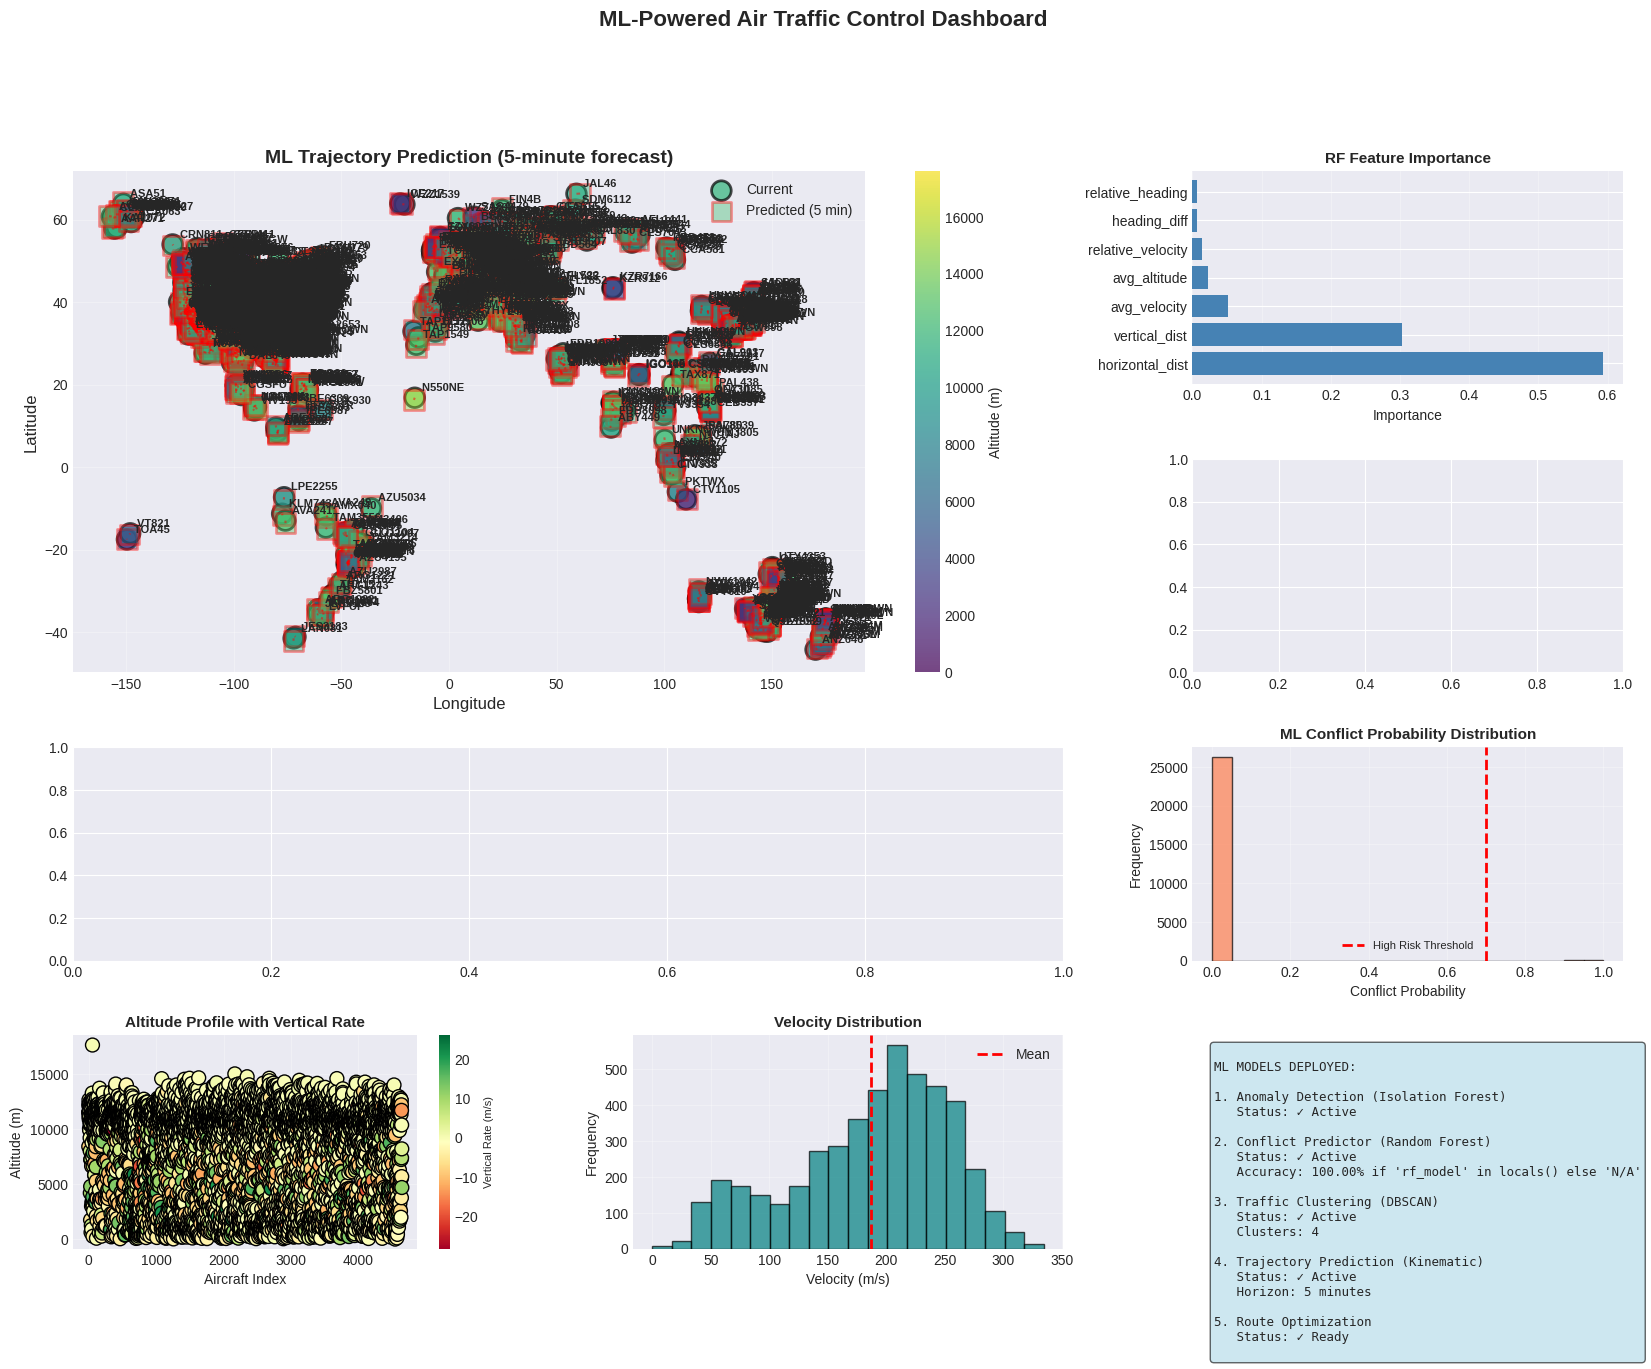

✓ ML Dashboard generated


In [ ]:
print("\n" + "="*80)
print("GENERATING ML-POWERED VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

airborne = df[df['onground'] == False]

# 1. Current and Predicted Positions
ax1 = fig.add_subplot(gs[0:2, 0:2])
if len(airborne) > 0:
    # Current positions
    scatter = ax1.scatter(airborne['lon'], airborne['lat'],
                         c=airborne['geoaltitude'], s=200,
                         cmap='viridis', alpha=0.7, edgecolors='black',
                         linewidths=2, label='Current')

    # Predicted positions
    if len(trajectory_predictions) > 0:
        ax1.scatter(trajectory_predictions['predicted_lon'],
                   trajectory_predictions['predicted_lat'],
                   c=trajectory_predictions['predicted_alt'], s=200,
                   cmap='viridis', alpha=0.4, edgecolors='red',
                   linewidths=2, marker='s', label='Predicted (5 min)')

        # Draw trajectory lines
        for idx in range(len(trajectory_predictions)):
            row = trajectory_predictions.iloc[idx]
            ax1.plot([row['current_lon'], row['predicted_lon']],
                    [row['current_lat'], row['predicted_lat']],
                    'r--', alpha=0.5, linewidth=1.5)

    # Add labels
    for _, aircraft in airborne.iterrows():
        ax1.annotate(aircraft['callsign'], (aircraft['lon'], aircraft['lat']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold')

    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.set_title('ML Trajectory Prediction (5-minute forecast)',
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Altitude (m)', fontsize=10)

# 2. Feature Importance
ax2 = fig.add_subplot(gs[0, 2])
if 'feature_importance' in locals():
    top_features = feature_importance.head(7)
    ax2.barh(top_features['feature'], top_features['importance'], color='steelblue')
    ax2.set_xlabel('Importance')
    ax2.set_title('RF Feature Importance', fontweight='bold', fontsize=11)
    ax2.grid(True, alpha=0.3, axis='x')

# 3. Anomaly Detection
ax3 = fig.add_subplot(gs[1, 2])
if 'airborne' in locals() and 'anomaly' in airborne.columns:
    anomaly_counts = airborne['anomaly'].value_counts()
    labels = ['Normal', 'Anomaly']
    colors = ['green', 'red']
    ax3.pie([anomaly_counts.get(1, 0), anomaly_counts.get(-1, 0)],
            labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title('Anomaly Detection Results', fontweight='bold')

# 4. Clustering Visualization
ax4 = fig.add_subplot(gs[2, 0:2])
if 'cluster' in airborne.columns:
    for cluster_id in airborne['cluster'].unique():
        cluster_data = airborne[airborne['cluster'] == cluster_id]
        if cluster_id == -1:
            ax4.scatter(cluster_data['lon'], cluster_data['lat'],
                       c='gray', s=100, alpha=0.5, label='Isolated', marker='x')
        else:
            ax4.scatter(cluster_data['lon'], cluster_data['lat'],
                       s=150, alpha=0.7, label=f'Cluster {cluster_id}')

    ax4.set_xlabel('Longitude')
    ax4.set_ylabel('Latitude')
    ax4.set_title('Traffic Clustering (DBSCAN)', fontweight='bold', fontsize=12)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)

# 5. Conflict Probability Distribution
ax5 = fig.add_subplot(gs[2, 2])
if 'current_conflicts' in locals() and len(current_conflicts) > 0:
    ax5.hist(current_conflicts['conflict_probability'], bins=20,
            edgecolor='black', alpha=0.7, color='coral')
    ax5.axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
    ax5.set_xlabel('Conflict Probability')
    ax5.set_ylabel('Frequency')
    ax5.set_title('ML Conflict Probability Distribution', fontweight='bold', fontsize=11)
    ax5.legend(fontsize=8)
    ax5.grid(True, alpha=0.3)

# 6. Altitude Profile
ax6 = fig.add_subplot(gs[3, 0])
if len(airborne) > 0:
    ax6.scatter(airborne.index, airborne['geoaltitude'],
               c=airborne['vertrate'], cmap='RdYlGn', s=100, edgecolors='black')
    ax6.set_xlabel('Aircraft Index')
    ax6.set_ylabel('Altitude (m)')
    ax6.set_title('Altitude Profile with Vertical Rate', fontweight='bold', fontsize=11)
    ax6.grid(True, alpha=0.3)
    cbar = plt.colorbar(ax6.collections[0], ax=ax6)
    cbar.set_label('Vertical Rate (m/s)', fontsize=8)

# 7. Speed Distribution
ax7 = fig.add_subplot(gs[3, 1])
if len(airborne) > 0:
    ax7.hist(airborne['velocity'], bins=20, edgecolor='black', alpha=0.7, color='teal')
    ax7.axvline(x=airborne['velocity'].mean(), color='red',
               linestyle='--', linewidth=2, label='Mean')
    ax7.set_xlabel('Velocity (m/s)')
    ax7.set_ylabel('Frequency')
    ax7.set_title('Velocity Distribution', fontweight='bold', fontsize=11)
    ax7.legend()
    ax7.grid(True, alpha=0.3)

# 8. ML Model Summary
ax8 = fig.add_subplot(gs[3, 2])
ax8.axis('off')

ml_summary = f"""
ML MODELS DEPLOYED:

1. Anomaly Detection (Isolation Forest)
   Status: {'✓ Active' if 'iso_forest' in locals() else '✗ Inactive'}

2. Conflict Predictor (Random Forest)
   Status: {'✓ Active' if 'rf_model' in locals() else '✗ Inactive'}
   Accuracy: {rf_model.score(X_test, y_test):.2%} if 'rf_model' in locals() else 'N/A'

3. Traffic Clustering (DBSCAN)
   Status: {'✓ Active' if 'dbscan' in locals() else '✗ Inactive'}
   Clusters: {n_clusters if 'n_clusters' in locals() else 'N/A'}

4. Trajectory Prediction (Kinematic)
   Status: {'✓ Active' if len(trajectory_predictions) > 0 else '✗ Inactive'}
   Horizon: 5 minutes

5. Route Optimization
   Status: ✓ Ready
"""

ax8.text(0.05, 0.95, ml_summary, transform=ax8.transAxes, fontsize=9,
        verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))

plt.suptitle('ML-Powered Air Traffic Control Dashboard',
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("✓ ML Dashboard generated")


## ML-Powered Decision Support & Actionable Recommendations

This cell consolidates outputs from all preceding models and translates them into
**prioritized, human-actionable recommendations**. Rather than presenting raw model
predictions, it synthesizes anomalies, conflict risks, airspace congestion, and
look-ahead alerts into clear guidance suitable for operational decision-making.

Recommendations are generated from multiple sources, including:
- Individual aircraft anomaly detection
- Current conflict risk assessment
- Airspace congestion analysis
- Predicted future conflicts

Each recommendation is assigned a priority level and confidence indicator, allowing
operators to quickly identify the most critical situations and respond appropriately.

This step represents the final **decision-support layer**, bridging machine learning
insights with real-world air traffic control actions.


In [ ]:
print("\n" + "="*80)
print("ML-POWERED RECOMMENDATIONS")
print("="*80)

recommendations = []

# ------------------------------------------------------------------
# 1. From anomaly detection (ML)
# ------------------------------------------------------------------
if 'anomalies' in locals() and len(anomalies) > 0:
    for _, aircraft in anomalies.head(5).iterrows():
        recommendations.append({
            'Type': 'ANOMALY ALERT',
            'Aircraft': aircraft['callsign'],
            'Issue': f"Unusual flight pattern detected (score: {aircraft['anomaly_score']:.2f})",
            'Action': 'Investigate aircraft behavior (possible emergency or pilot deviation)',
            'Priority': 'HIGH',
            'Source': 'ML',
            'Confidence': 'High'
        })

# ------------------------------------------------------------------
# 2. From current conflict prediction (ML)
# ------------------------------------------------------------------
if 'high_risk' in locals() and len(high_risk) > 0:
    for _, conflict in high_risk.head(5).iterrows():
        recommendations.append({
            'Type': 'CONFLICT ALERT',
            'Aircraft': 'Multiple aircraft',
            'Issue': f"Conflict probability: {conflict['conflict_probability']:.1%}",
            'Action': 'Issue immediate separation instructions',
            'Priority': 'CRITICAL',
            'Source': 'ML',
            'Confidence': f"{conflict['conflict_probability']:.0%}"
        })

# ------------------------------------------------------------------
# 3. From traffic clustering (unsupervised ML)
# ------------------------------------------------------------------
if (
    'airborne' in locals() and
    isinstance(airborne, pd.DataFrame) and
    'cluster' in airborne.columns
):
    cluster_sizes = (
        airborne[airborne['cluster'] != -1]['cluster']
        .value_counts()
    )
    congested_clusters = cluster_sizes[cluster_sizes >= 3]

    if len(congested_clusters) > 0:
        for cluster_id in congested_clusters.index[:3]:
            cluster_aircraft = airborne[airborne['cluster'] == cluster_id]

            recommendations.append({
                'Type': 'CONGESTION WARNING',
                'Aircraft': f"{len(cluster_aircraft)} aircraft",
                'Issue': f"High traffic density detected (Cluster {cluster_id})",
                'Action': 'Proactively redistribute traffic (altitude / heading adjustments)',
                'Priority': 'MEDIUM',
                'Source': 'Unsupervised ML',
                'Confidence': 'High'
            })

# ------------------------------------------------------------------
# 4. From future conflict prediction (Hybrid)
# ------------------------------------------------------------------
if 'future_conflicts' in locals() and len(future_conflicts) > 0:
    for conflict in future_conflicts[:3]:
        recommendations.append({
            'Type': 'FUTURE CONFLICT',
            'Aircraft': f"{conflict['Aircraft_1']} & {conflict['Aircraft_2']}",
            'Issue': f"Predicted conflict in {conflict['Time_to_Conflict_min']} minutes",
            'Action': 'Initiate preventive separation now',
            'Priority': 'HIGH',
            'Source': 'Hybrid (Trajectory + ML)',
            'Confidence': 'Medium–High'
        })

# ------------------------------------------------------------------
# 5. Present recommendations (sorted by priority)
# ------------------------------------------------------------------
priority_order = {'CRITICAL': 0, 'HIGH': 1, 'MEDIUM': 2, 'LOW': 3}

recommendations = sorted(
    recommendations,
    key=lambda x: priority_order.get(x['Priority'], 99)
)

if recommendations:
    recommendations_df = pd.DataFrame(recommendations)
    print(f"\n✓ {len(recommendations_df)} actionable recommendation(s) generated:\n")
    print(recommendations_df.to_string(index=False))
else:
    print("\n✓ No critical actions required at this time")



ML-POWERED RECOMMENDATIONS

✓ 13 actionable recommendation(s) generated:

           Type            Aircraft                                          Issue                                                                Action Priority                   Source  Confidence
 CONFLICT ALERT   Multiple aircraft                    Conflict probability: 98.0%                               Issue immediate separation instructions CRITICAL                       ML         98%
 CONFLICT ALERT   Multiple aircraft                    Conflict probability: 99.0%                               Issue immediate separation instructions CRITICAL                       ML         99%
 CONFLICT ALERT   Multiple aircraft                    Conflict probability: 82.9%                               Issue immediate separation instructions CRITICAL                       ML         83%
 CONFLICT ALERT   Multiple aircraft                   Conflict probability: 100.0%                               Issue immediate 